This notebook solves the problem set by `deep_macrofin` package. `deep_macrofin` use neural network to approximate $q$, $\kappa$ and $\sigma^q$. In the following, We first estimate the model using `deep_macrofin` and then compare the result with the result estimated by the Newton method.

## deep_macrofin

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, System, OptimizerType, plot_loss_df,  set_seeds, SamplingMethod
torch.set_default_dtype(torch.float64) # Set default data type for torch tensors to double precision

`deep_macrofin` supports LATEX-based formula. We only need to define `latex_var_mapping` to include all possible LATEX to Python name conversions.

In [2]:
latex_var_mapping = {
    r"\eta": "eta",
    
    r"q": "q",
    r"\kappa": "kappa",
    r"\sigma^q": "sigmaq",
    
    r"\iota": "iota",
    
    r"\rho^e": "rhoe",
    r"\rho^h": "rhoh",
    r"\delta": "delta",
    r"a^e": "ae",
    r"a^h": "ah",
    r"\sigma": "sigma",
    r"\phi": "phi"
}

Define the constant parameters in a dictionary.

In [3]:
params = {
    "rhoe": 0.06,
    "rhoh": 0.04,
    "delta": 0.05,
    "ae": 0.11,
    "ah": 0.07,
    "sigma": 0.10,
    "phi": 10
}

There are two regime in the model: (1) the unconstrained regime $\kappa<1$, and (2) the constrained regime $\kappa=1$. To ensure the accuracy, we separately solve the two regimes and then combine them together. 

### 1 Unconstrained regime

Firstly, lets define the unconstrained regime use the class `PDEModel`. 
- `name` is the just a label for convenience when checking the model.
- `latex_var_mapping` includes all possible latex to python name conversions.
- `config` includes training basics for the NN. Specifically, we use `SamplingMethod.FixedGrid` and `batch_size = 1000` to indicate that $\eta$ is sampled on a fixed grid with 1000 points. `num_epochs` is the number of epoch to train the NN. `OptimizerType.Adam` is a fast optimization algorithm. All other configs are default.

In [4]:
batch_size = 1000
set_seeds(0)
pde_model_unconstrain = PDEModel(name = "BruSan14_log_utility", 
                                 latex_var_mapping=latex_var_mapping, 
                                 config={"sampling_method": SamplingMethod.FixedGrid, 
                                         "batch_size": batch_size,
                                         "num_epochs": 20000,
                                         "optimizer_type": OptimizerType.Adam})

In the unconstrained regime $\kappa<1$, we need to solve the below ODE system:
$$
\begin{cases}
&\kappa a^e + (1 - \kappa) a^h - \iota - q (\eta \rho^e + (1 - \eta) \rho^h) = 0 \\
&\frac{\partial q}{\partial \eta} (\kappa - \eta) (\sigma + \sigma^q) - \sigma^q q = 0\\
&a^e - a^h - \frac{q (\kappa - \eta)}{(1 - \eta)" \eta} (\sigma + \sigma^q)^2 = 0
\end{cases}
$$
where $\eta$ is the state variable, $(q, \kappa, \sigma^q)$ are functions of $\eta$. We parameterize by Neural Network (NN) $(q, \kappa, \sigma^q)$ where $\eta$ is the input.

In general, we can follow below 6 steps to enter our model:

##### Step 1: define the state variables

In [5]:
pde_model_unconstrain.set_state(["eta"], {"eta": [0.001, 0.999]})  

##### Step 2: define learnable variables. 

In our case (log utility), we use `add_endogs` to define $(q, \kappa, \sigma^q)$ as endogenous variables. 
- `names` is a list of variables.
- `configs` includes the structure of each NN. We use `ActivationType.SiLU` (check detail [here](https://pytorch.org/docs/stable/generated/torch.nn.SiLU.html)) as the activation function. `positive` indicates the endogenous variable is always positive. Here, we need $q$ and $\kappa$ to be positive.

In [6]:
pde_model_unconstrain.add_endogs(names = ["q", "kappa", "sigmaq"], 
                                 configs={"q": {"positive": True, "activation_type": ActivationType.SiLU},
                                          "kappa": {"positive": True, "activation_type": ActivationType.SiLU},
                                          "sigmaq": {"positive": False, "activation_type": ActivationType.SiLU}})

##### Step 3: define parameters.

In [7]:
pde_model_unconstrain.add_params(params)

##### Step 4: add the boundary conditions
In our unconstrained regime, we have 6 boundary conditions in total: 

At $\eta = 0$, 

$$
\begin{cases}
q &= \frac{\phi a^h + 1}{\phi \rho^h + 1} \\
\kappa &= 0\\
\sigma^q &= 0
\end{cases}
$$

At $\eta = 1$,

$$
\begin{cases}
q &= \frac{\phi a^e + 1}{\phi \rho^e + 1}\\
\kappa &= 1\\
\sigma^q &= 0
\end{cases}
$$

We use `add_endog_condition` to add the boundary conditions.
- `name` is the name of the endogenous variable.
- `label` is the just a label for convenience when checking the model.
- `lhs` denotes the left-hand-side of the boundary condition.
- `lhs_state` explains the notation you used in `lhs`. For example, `"q(SV)"` denotes the function $q(0)$, so we need to include `{"SV": torch.zeros((1, 1))}` in `lhs_state`. Note, we don't need to write endogenous variables in `lhs_state`.
- `rhs` denotes the right-hand-side of the boundary condition.
- `rhs_state` explains the notation you used in `rhs`.
- `comparator` denotes the sign of boundary condition. Here, `Comparator.EQ` denotes "lhs=rhs".
- `weight` denotes the weight of the loss. Detailed explanation in Step 5

In [8]:
pde_model_unconstrain.add_endog_condition(name="q", 
                              lhs = "q(SV)",
                              lhs_state = {"SV": torch.zeros((1, 1))},
                              comparator = Comparator.EQ,
                              rhs = "(phi*ah + 1)/(phi*rhoh + 1)",
                              rhs_state = pde_model_unconstrain.variable_val_dict,
                              label="q_min",
                              weight=batch_size/10)
pde_model_unconstrain.add_endog_condition(name="q",
                              lhs = "q(SV)",
                              lhs_state = {"SV": torch.ones((1, 1))},
                              comparator = Comparator.EQ,
                              rhs = "(phi*ae + 1)/(phi*rhoe + 1)",
                              rhs_state = pde_model_unconstrain.variable_val_dict,
                              label="q_max",
                              weight=batch_size/10)
pde_model_unconstrain.add_endog_condition(name="kappa",
                              lhs = "kappa(SV)",
                              lhs_state = {"SV": torch.zeros((1, 1))},
                              comparator = Comparator.EQ,
                              rhs = "0",
                              rhs_state = pde_model_unconstrain.variable_val_dict,
                              label="kappa_min",
                              weight=batch_size/10)
pde_model_unconstrain.add_endog_condition(name="kappa",
                              lhs = "kappa(SV)",
                              lhs_state = {"SV": torch.ones((1, 1))},
                              comparator = Comparator.EQ,
                              rhs = "1",
                              rhs_state = pde_model_unconstrain.variable_val_dict,
                              label="kappa_max",
                              weight=batch_size/10)
pde_model_unconstrain.add_endog_condition(name="sigmaq",
                              lhs = "sigmaq(SV)",
                              lhs_state = {"SV": torch.zeros((1, 1))},
                              comparator = Comparator.EQ,
                              rhs = "0",
                              rhs_state = pde_model_unconstrain.variable_val_dict,
                              label="sigmaq_min",
                              weight=batch_size/10)
pde_model_unconstrain.add_endog_condition(name="sigmaq",
                              lhs = "sigmaq(SV)",
                              lhs_state = {"SV": torch.ones((1, 1))},
                              comparator = Comparator.EQ,
                              rhs = "0",
                              rhs_state = pde_model_unconstrain.variable_val_dict,
                              label="sigmaq_max",
                              weight=batch_size/10)

##### Step 5: add equations for learnable variables. 

In our case (log utility), we use `add_endog_equation` input the following three equations. Note, use `*` for multiplication.
$$
\begin{cases}
&\kappa a^e + (1 - \kappa) a^h - \iota - q (\eta \rho^e + (1 - \eta) \rho^h) = 0 \\
&\frac{\partial q}{\partial \eta} (\kappa - \eta) (\sigma + \sigma^q) - \sigma^q q = 0\\
&a^e - a^h - \frac{q (\kappa - \eta)}{(1 - \eta)" \eta} (\sigma + \sigma^q)^2 = 0
\end{cases}
$$

`weight` is significant in our estimation. In `deep_macrofin`, the loss function is a weighted sum of losses for all boundary conditions, endogenous equations, etc. MSE is the default loss. However, in our case, each boundary condition corresponds to one point on the line (e.g. $q(\eta)$). Each endogenous equation corresponds to 1000 (batch size) points on the line. Therefore, the MSE loss implicitly assumes that the boundary point is 1000 times more important than other points on the line. We need to change the weight so that the boundary conditions are less important and the endogenous equations are more important. Meanwhile, we put more weight on the last equation because the square dilutes the change of $\sigma^q$.

In [9]:
pde_model_unconstrain.add_endog_equation(r"$\kappa*a^e + (1 - \kappa)*a^h - \iota - q * ( \eta *\rho^e + (1 - \eta) *\rho^h ) = 0$", weight=batch_size) 
pde_model_unconstrain.add_endog_equation(r"$\frac{\partial q}{\partial \eta}* (\kappa - \eta) *(\sigma + \sigma^q) - \sigma^q *q = 0$", weight=batch_size)
pde_model_unconstrain.add_endog_equation(r"$a^e - a^h - \frac{q* (\kappa - \eta)}{(1 - \eta) *\eta} * (\sigma + \sigma^q)^2 = 0$", weight=batch_size*2)

##### Step 6: add equations for other variables

Here we have $\iota$ as a function of $q$. We use `add_equation`.

$$\iota = \frac{1}{\phi} (q - 1)$$

In [10]:
pde_model_unconstrain.add_equation(r"$\iota = \frac{1}{\phi} * (q - 1)$")

Now, we are ready to train and plot the model in the unconstrained regime.

====================================Training====================================


Total loss: 0.0025: 100%|██████████| 20000/20000 [11:04<00:00, 30.10it/s]


training finished, total time :: 664.3708562850952
Best model saved to ./models/PS03/PS03_best.pt if valid
Model saved to ./models/PS03/PS03.pt
Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0000,
endogvar_q_cond_q_max: 0.0000,
endogvar_kappa_cond_kappa_min: 0.0000,
endogvar_kappa_cond_kappa_max: 0.0000,
endogvar_sigmaq_cond_sigmaq_min: 0.0000,
endogvar_sigmaq_cond_sigmaq_max: 0.0000,
endogeq_1: 0.0000,
endogeq_2: 0.0000,
endogeq_3: 0.0000,
total_loss: 0.0078


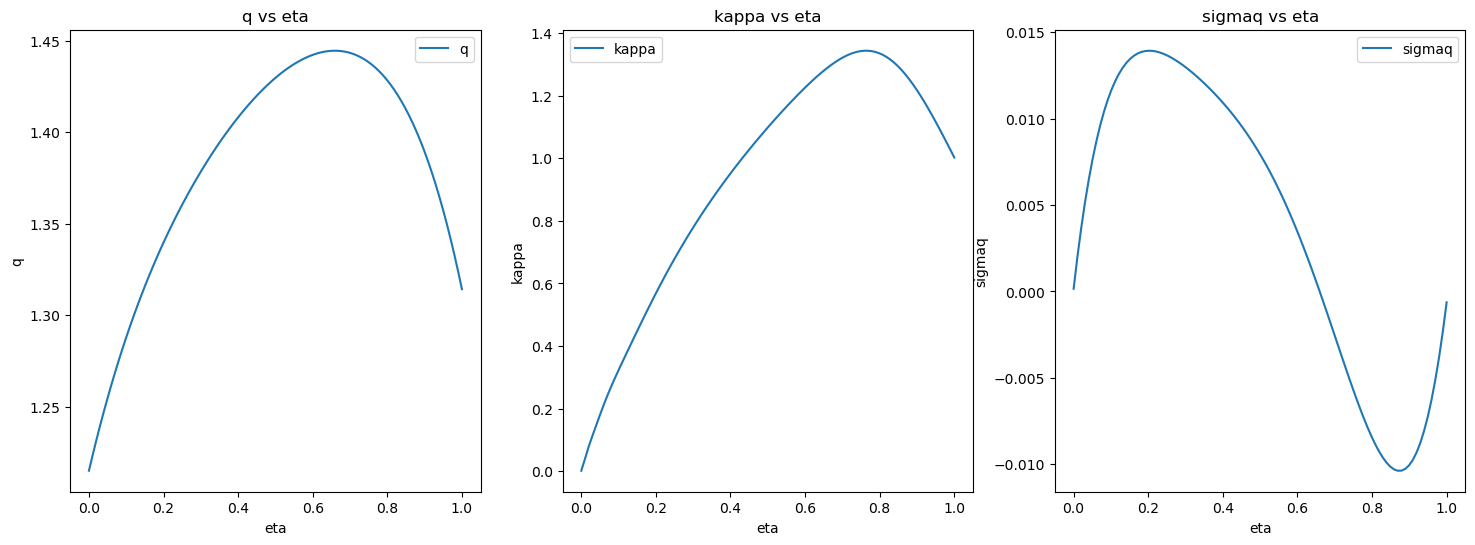

In [11]:
pde_model_unconstrain.train_model("./models/PS03", "PS03.pt", True)
pde_model_unconstrain.load_model(torch.load("./models/PS03/PS03.pt"))
pde_model_unconstrain.eval_model(True)

N = 1001
eta = torch.linspace(0, 1, N, device='cuda').reshape(-1, 1)
q_nn_unconstrain = pde_model_unconstrain.endog_vars["q"](eta).detach().cpu().numpy().reshape(-1)
kappa_nn_unconstrain = pde_model_unconstrain.endog_vars["kappa"](eta).detach().cpu().numpy().reshape(-1)
sigmaq_nn_unconstrain = pde_model_unconstrain.endog_vars["sigmaq"](eta).detach().cpu().numpy().reshape(-1)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
pde_model_unconstrain.endog_vars["q"].plot("q", {"eta": [0, 1]}, ax=ax[0])
pde_model_unconstrain.endog_vars["kappa"].plot("kappa", {"eta": [0, 1]}, ax=ax[1])
pde_model_unconstrain.endog_vars["sigmaq"].plot("sigmaq", {"eta": [0, 1]}, ax=ax[2])
plt.subplots_adjust()
plt.show()

### 2 Constrained regime

In the constrained regime, we take $\kappa = 1$ and estimate the model again. We need to solve the below ODE system:
$$
\begin{cases}
&\kappa a^e + (1 - \kappa) a^h - \iota - q (\eta \rho^e + (1 - \eta) \rho^h) = 0 \\
&\frac{\partial q}{\partial \eta} (\kappa - \eta) (\sigma + \sigma^q) - \sigma^q q = 0
\end{cases}
$$
where $\eta$ is the state variable, $(q, \sigma^q)$ are functions of $\eta$. We parameterize by Neural Network (NN) $(q, \sigma^q)$ where $\eta$ is the input.

Although the ODE equation system above has a closed form solution, we pretend we do not know the solution and use NN to find the it. Since the ODE system is easier to estimate, we reduce the `num_epochs` to 2000.

In [12]:
pde_model_constrain = PDEModel(name = "BruSan14_log_utility",
                               latex_var_mapping=latex_var_mapping, 
                               config={"sampling_method": SamplingMethod.FixedGrid,
                                       "batch_size": batch_size,
                                       "num_epochs": 2000,
                                       "optimizer_type": OptimizerType.Adam})

##### Step 1: define the state variables

In [13]:
pde_model_constrain.set_state(["eta"], {"eta": [0.001, 0.999]})  

##### Step 2: define learnable variables. 

In [14]:
pde_model_constrain.add_endogs(["q", "sigmaq"], configs={
    "q": {"positive": True, "activation_type": ActivationType.SiLU}, 
    "sigmaq": {"positive": False, "activation_type": ActivationType.SiLU}
})

##### Step 3: define parameters.

In the constrained regime, we take $\kappa$ as a constant parameter

In [15]:
pde_model_constrain.add_params(params|{"kappa": 1})

##### Step 4: add the boundary conditions

In the constrained regime, there's no boundary conditions.

##### Step 5: add equations for learnable variables. 

$$
\begin{cases}
&\kappa a^e + (1 - \kappa) a^h - \iota - q (\eta \rho^e + (1 - \eta) \rho^h) = 0 \\
&\frac{\partial q}{\partial \eta} (\kappa - \eta) (\sigma + \sigma^q) - \sigma^q q = 0
\end{cases}
$$

In [16]:
pde_model_constrain.add_endog_equation(r"$\kappa*a^e + (1 - \kappa)*a^h - \iota - q * ( \eta *\rho^e + (1 - \eta) *\rho^h ) = 0$", weight=batch_size) 
pde_model_constrain.add_endog_equation(r"$\frac{\partial q}{\partial \eta}* (\kappa - \eta) *(\sigma + \sigma^q) - \sigma^q *q = 0$", weight=batch_size)

##### Step 6: add equations for other variables

$$\iota = \frac{1}{\phi} (q - 1)$$

In [17]:
pde_model_constrain.add_equation(r"$\iota = \frac{1}{\phi} * (q - 1)$")

Train and plot the model in the constrained regime.

====================================Training====================================


  0%|          | 0/2000 [00:00<?, ?it/s]

Total loss: 0.0000: 100%|██████████| 2000/2000 [00:33<00:00, 60.14it/s]


training finished, total time :: 33.25660705566406
Best model saved to ./models/PS03_constrain/PS03_constrain_best.pt if valid
Model saved to ./models/PS03_constrain/PS03_constrain.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
total_loss: 0.0000


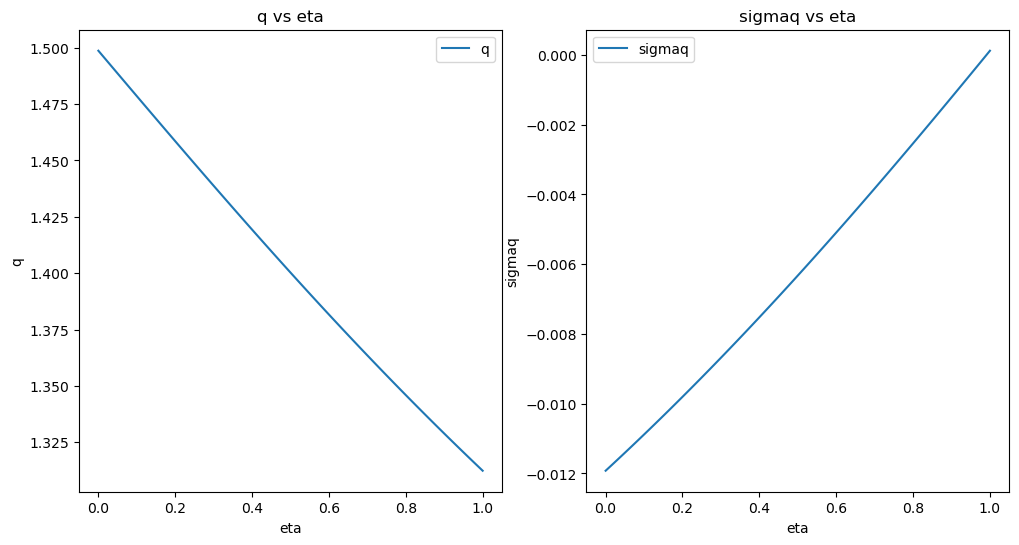

In [18]:
pde_model_constrain.train_model("./models/PS03_constrain", "PS03_constrain.pt", True)
pde_model_constrain.load_model(torch.load("./models/PS03_constrain/PS03_constrain.pt"))
pde_model_constrain.eval_model(True)

N = 1001
eta = torch.linspace(0, 1, N, device='cuda').reshape(-1, 1)
q_nn_constrain = pde_model_constrain.endog_vars["q"](eta).detach().cpu().numpy().reshape(-1)
sigmaq_nn_constrain = pde_model_constrain.endog_vars["sigmaq"](eta).detach().cpu().numpy().reshape(-1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pde_model_constrain.endog_vars["q"].plot("q", {"eta": [0, 1]}, ax=ax[0])
pde_model_constrain.endog_vars["sigmaq"].plot("sigmaq", {"eta": [0, 1]}, ax=ax[1])
plt.subplots_adjust()
plt.show()

### 2 Combine the constrained and unconstrained regime

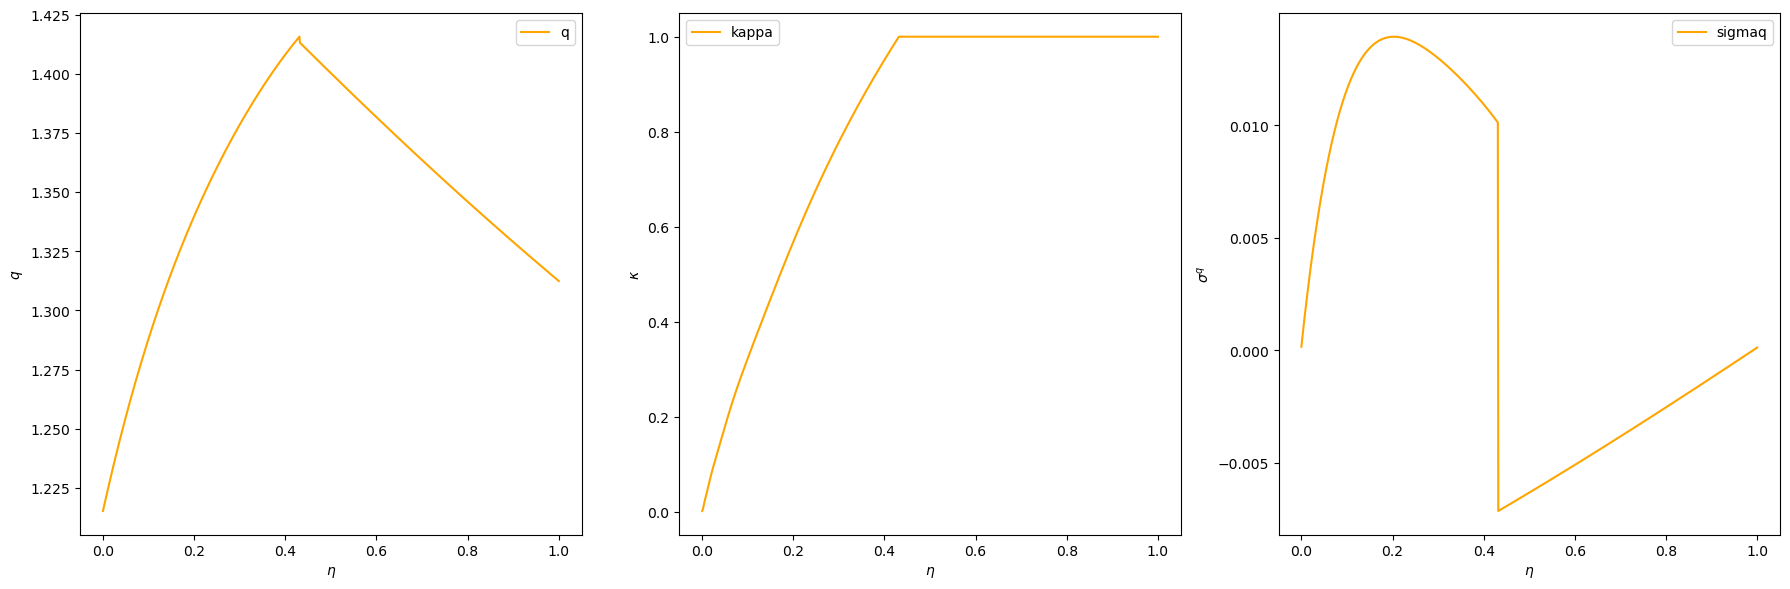

In [26]:
index_unconstrain = (kappa_nn_unconstrain<1)
index_constrain = (kappa_nn_unconstrain>=1)

kappa_nn = kappa_nn_unconstrain*index_unconstrain + 1*index_constrain
q_nn = q_nn_unconstrain*index_unconstrain + q_nn_constrain*index_constrain
sigmaq_nn = sigmaq_nn_unconstrain*index_unconstrain + sigmaq_nn_constrain*index_constrain

N = 1001
eta = np.linspace(0, 1, N)
fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].plot(eta, q_nn, label='q', color='orange')
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel(r'$q$')
ax[0].legend()
ax[1].plot(eta, kappa_nn, label='kappa', color='orange')
ax[1].set_xlabel(r'$\eta$')
ax[1].set_ylabel(r'$\kappa$')
ax[1].legend()
ax[2].plot(eta, sigmaq_nn, label='sigmaq', color='orange')
ax[2].set_xlabel(r'$\eta$')
ax[2].set_ylabel(r'$\sigma^q$')
ax[2].legend()
fig.tight_layout()
plt.show()

## Newton Method

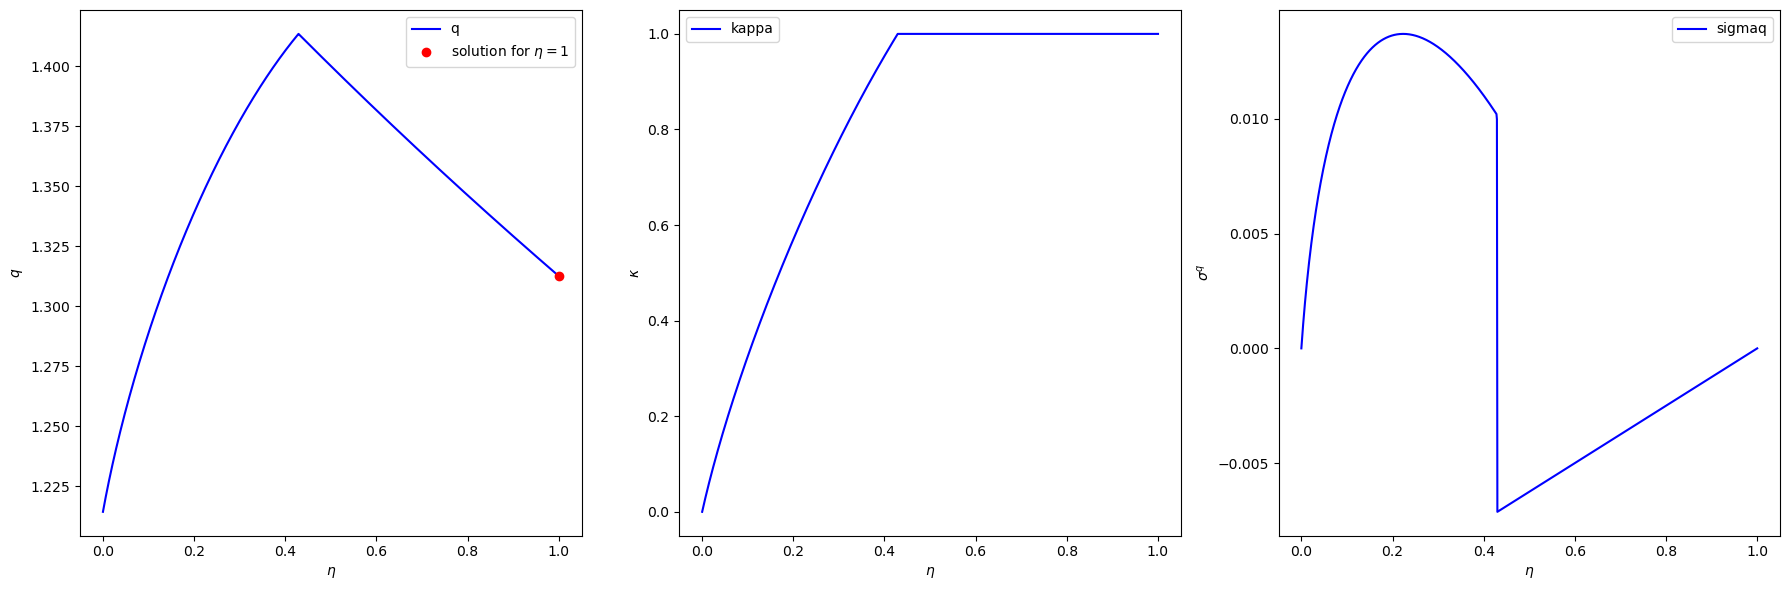

In [27]:
N = 1001
eta = np.linspace(0, 1, N)
h = eta[1]-eta[0]
globals().update(params) # unpack parameters
q_eta0=(phi*ah+1)/(phi*rhoh+1)
q_eta1=(phi*ae+1)/(phi*rhoe+1)

def F(q, kappa, sigmaq, eta, q0):
    return np.array([[kappa*ae + (1-kappa)*ah - 1/phi*(q-1) -q*(eta*rhoe+(1-eta)*rhoh)],
                    [(q-q0)/h*(kappa-eta)*(sigma+sigmaq)-sigmaq*q],
                    [(ae-ah) - q*(kappa-eta)/((1-eta)*eta)*(sigma+sigmaq)**2]])

def DF(q, kappa, sigmaq, eta, q0):
    return np.array([[-1/phi-(eta*rhoe+(1-eta)*rhoh),               ae-ah,                               0                                            ],
                    [1/h*(kappa-eta)*(sigma+sigmaq)-sigmaq,         (q-q0)/h*(sigma+sigmaq),             (q-q0)/h*(kappa-eta)-q                       ],
                    [-(kappa-eta)/((1-eta)*eta)*(sigma+sigmaq)**2,  -q*(sigma+sigmaq)**2/((1-eta)*eta),  -2*q*(kappa-eta)/((1-eta)*eta)*(sigma+sigmaq)]])
    
def Newton(z_guess, eta):
    q0 = z_guess[0,0]
    z = z_guess
    while True:
        z_new = z - np.linalg.inv(DF(z[0,0], z[1,0], z[2,0], eta, q0))@F(z[0,0], z[1,0], z[2,0], eta, q0)
        if (np.abs(z_new - z)< 1e-8).all():
            break
        else:
            z = z_new
    return z_new

def F_fix_kappa(q, sigmaq, eta, q0):
    return np.array([[ae-1/phi*(q-1)-q*(eta*rhoe+(1-eta)*rhoh)],
                    [(q-q0)/h*(1-eta)*(sigma+sigmaq)-sigmaq*q]])

def DF_fix_kappa(q, sigmaq, eta, q0):
    return np.array([[-1/phi-(eta*rhoe+(1-eta)*rhoh),    0                 ],
                    [1/h*(1-eta)*(sigma+sigmaq)-sigmaq,  (q-q0)/h*(1-eta)-q]])
    
def Newton_fix_kappa(z_guess, eta):
    q0 = z_guess[0,0]
    z = z_guess
    while True:
        z_new = z - np.linalg.inv(DF_fix_kappa(z[0,0], z[1,0], eta, q0))@F_fix_kappa(z[0,0], z[1,0], eta, q0)
        if (np.abs(z_new - z)< 1e-8).all():
            break
        else:
            z = z_new
    return z_new


z_list = np.zeros((3, len(eta)))
z_list[:,[0]] = np.array([[q_eta0],[0],[0]])

for i in range(1, len(eta)):
    z_guess = z_list[:,[i-1]]
    z_list[:,[i]] = Newton(z_guess, eta[i])
    if z_list[[1],[i]]>1:
        break
for j in range(i, len(eta)):
    z_guess = z_list[[[0],[2]],[j-1]]
    z_list[[[0],[2]],[j]] = Newton_fix_kappa(z_guess, eta[j])
    z_list[1,[j]] = 1
        
q = z_list[0,:]
kappa = z_list[1,:]
sigmaq = z_list[2,:]
iota = 1/phi*(q-1)

fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].plot(eta, q, label='q', color='blue')
ax[0].plot(1, q_eta1, 'ro', label=r'solution for $\eta=1$')
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel(r'$q$')
ax[0].legend()
ax[1].plot(eta, kappa, label='kappa', color='blue')
ax[1].set_xlabel(r'$\eta$')
ax[1].set_ylabel(r'$\kappa$')
ax[1].legend()
ax[2].plot(eta, sigmaq, label='sigmaq', color='blue')
ax[2].set_xlabel(r'$\eta$')
ax[2].set_ylabel(r'$\sigma^q$')
ax[2].legend()
fig.tight_layout()
plt.show()

## Comparison between neural network and Newton method

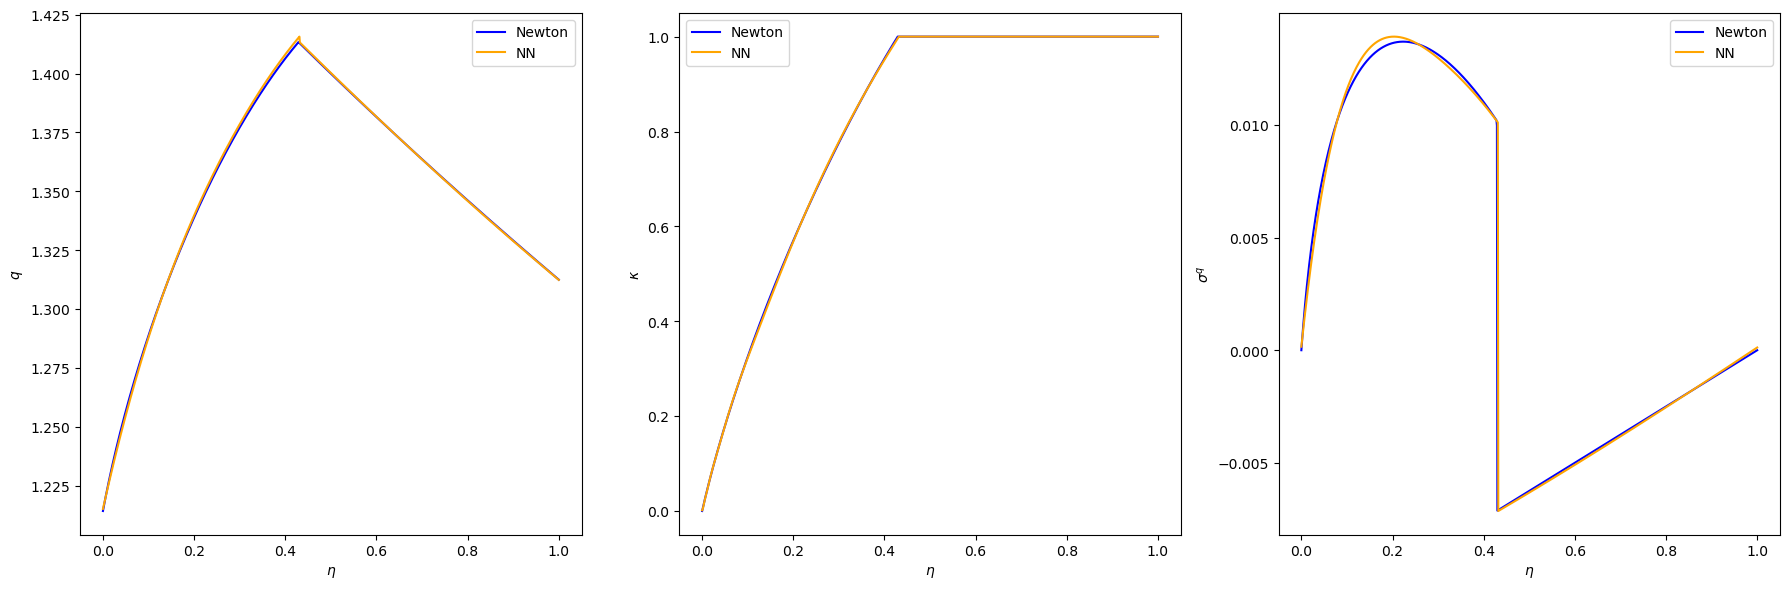

In [28]:
fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].plot(eta, q, label='Newton', color='blue')
ax[0].plot(eta, q_nn, label='NN', color='orange')
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel(r'$q$')
ax[0].legend()
ax[1].plot(eta, kappa, label='Newton', color='blue')
ax[1].plot(eta, kappa_nn, label='NN', color='orange')
ax[1].set_xlabel(r'$\eta$')
ax[1].set_ylabel(r'$\kappa$')
ax[1].legend()
ax[2].plot(eta, sigmaq, label='Newton', color='blue')
ax[2].plot(eta, sigmaq_nn, label='NN', color='orange')
ax[2].set_xlabel(r'$\eta$')
ax[2].set_ylabel(r'$\sigma^q$')
ax[2].legend()
fig.tight_layout()
plt.show()